# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F

from segmate import utils, segmenter

# Model Init
Initialize SAM model with ViT-H backbone

In [3]:
sam = segmenter.SAM(model_type='vit_h', checkpoint='/ssd003/projects/aieng/image_models/sam_vit_h.pth')

# Util Functions
Utility functions to support prompt tuning

In [4]:
def prepare_image(image: np.ndarray, model: segmenter.SAM) -> torch.Tensor:
    """
    Prepare image for SAM image encoder

    Args:
        image: image to prepare
        model: SAM model

    Returns:
        prepared input image
    """
    input_image = model.predictor.transform.apply_image(image)
    input_image = torch.as_tensor(input_image, device=model.device)
    input_image = input_image.permute(2, 0, 1).contiguous()[None, :, :, :]
    input_image = model.sam.preprocess(input_image)

    return input_image

In [5]:
def prepare_points(
        coords: np.ndarray, 
        labels: np.ndarray, 
        image: np.ndarray, 
        model: segmenter.SAM
    ) -> tuple[torch.Tensor, torch.Tensor]: 
    """
    Prepare points for SAM prompt encoder

    Args:
        coords: coordinates of points
        labels: labels of points
        image: input image
        model: SAM model

    Returns:
        prepared input points
    """
    coords_tensor = torch.tensor(coords).to(model.device).unsqueeze(1)
    labels_tensor = torch.tensor(labels).to(model.device).unsqueeze(1)
    coords_tensor = model.predictor.transform.apply_coords_torch(
                coords_tensor, image.shape[:2])
    
    return coords_tensor, labels_tensor

In [6]:
def generate_trained_emb_mask(
        model: segmenter.SAM, 
        input_image: np.ndarray, 
        trained_sparse_embedding: torch.Tensor, 
        fixed_dense_embedding: torch.Tensor, 
        original_size: tuple[int, int]
    ) -> np.ndarray:
    """
    Generate mask from trained embeddings

    Args:
        model: SAM model
        input_image: input image
        trained_sparse_embedding: trained sparse prompt embeddings
        fixed_dense_embedding: fixed dense prompt embeddings
        original_size: original size of image

    Returns:
        generated mask
    """
    with torch.no_grad():
        input_image = prepare_image(input_image, model)
        test_image_embedding = model.sam.image_encoder(input_image)

        raw_mask, _ = model.sam.mask_decoder(
            image_embeddings=test_image_embedding,
            image_pe=model.sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=trained_sparse_embedding,
            dense_prompt_embeddings=fixed_dense_embedding,
            multimask_output=True,
        )

        processed_mask = model.sam.postprocess_masks(
            raw_mask,
            input_size=(1024, 1024),
            original_size=original_size
        )
        processed_mask = processed_mask > model.sam.mask_threshold
        processed_mask_np = processed_mask.detach().cpu().numpy().astype(np.uint8)
    return processed_mask_np

In [7]:
def plot_train_val(training_loss: list, validation_loss: list) -> None:
    """
    Plot training and validation loss

    Args:
        training_loss: training loss
        validation_loss: validation loss
    """
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_loss, '-o', label='Training Loss')
    plt.plot(epochs, validation_loss, '-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

In [8]:
def dice_loss(predicted_mask: torch.Tensor, ground_truth_mask: torch.Tensor, epsilon: float=1e-6) -> torch.Tensor:
    """
    Calculate dice loss

    Args:
        predicted_mask: predicted mask
        ground_truth_mask: ground truth mask
        epsilon: epsilon value

    Returns:
        dice loss
    """
    predicted_mask = torch.sigmoid(predicted_mask)
    intersection = (predicted_mask * ground_truth_mask).sum()
    return 1 - (2. * intersection + epsilon) / (predicted_mask.sum() + ground_truth_mask.sum() + epsilon)

In [9]:
def focal_loss(pred: torch.Tensor, target: torch.Tensor, alpha: int=1, gamma: int=2, eps: float=1e-7) -> torch.Tensor:
    """
    Calculate focal loss

    Args:
        pred: predicted mask
        target: ground truth mask
        alpha: alpha value
        gamma: gamma value
        eps: epsilon value

    Returns:
        focal loss
    """
    pred_prob = torch.sigmoid(pred)
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    p_t = pred_prob * target + (1 - pred_prob) * (1 - target)
    modulating_factor = (1.0 - p_t).pow(gamma)
    loss = alpha * modulating_factor * bce
    return loss.mean()

In [10]:
def compute_metrics(predicted_mask: np.ndarray, ground_truth_mask: np.ndarray) -> tuple(float, float, float):
    """
    Compute accuracy, F1 score for binary masks.
    
    Args:
        predicted_mask (numpy array): Predicted binary mask.
        ground_truth_mask (numpy array): Ground truth binary mask.
    
    Returns:
        accuracy, f1_score, dice_score
    """

    # Basic metrics
    TP = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    FP = np.sum((predicted_mask == 1) & (ground_truth_mask == 0))
    TN = np.sum((predicted_mask == 0) & (ground_truth_mask == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth_mask == 1))

    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Precision and Recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Intersection
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    
    # Union
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    
    # IoU
    iou = intersection / union

    return accuracy, f1_score, iou


# Generate Frozen Embeddings and Ground Truth Masks
We use the "High Resolution Semantic Change Detection Dataset" for prompt tuning. This image size in 
this dataset is 10000x10000 pixels, which is too large for running inference using ViT-H backbone on 
T4 GPUs. To allow for quick inference and training, the images are split into 500x500 pixel segments. 

We also use the "create_prompts.ipynb" to generate point prompts which would yield ground truth masks
of trees in different segments of images. Here the "prompts.json" is generated from the aforementioned
notebook. 

For data preparation, we generate the image embeddings, prompt embeddings, and ground truth masks from
the manually generated prompts.

In [13]:
dataset_dir = "/ssd003/projects/aieng/public/semantic_change_detection_small_dataset"

with open("prompts.json", "r") as f:
    prompts = json.load(f)

embeddings = []
with torch.no_grad():    
    for prompt in tqdm(prompts):
        img = utils.load_image(dataset_dir+'/'+prompt['img_path'])
        part_img = img[prompt['x_range'][0]:prompt['x_range'][1], prompt['y_range'][0]:prompt['y_range'][1], :]
        input_image = prepare_image(part_img, sam)
        point_coords, point_labels = prepare_points(
            prompt['foreground_points'], [1] * len(prompt['foreground_points']), input_image, sam)

        image_embedding = sam.sam.image_encoder(input_image)
        sparse_embeddings, dense_embeddings = sam.sam.prompt_encoder(
            points=(point_coords, point_labels),
            boxes=None,
            masks=None,
        )

        gt_mask = sam.segment(
            part_img, 
            points_prompt=(prompt['foreground_points'], [1] * len(prompt['foreground_points'])), 
            multimask_output=True,
            convert_to_np=False
        )
        gt_raw_mask = gt_mask.any(0, keepdim=True)
        gt_raw_mask = sam.revert_postprocess(
            gt_raw_mask.float(), 
            (1024, 1024),
            (256, 256)
        )
        gt_raw_mask = gt_raw_mask > 0.5
        
        gt_mask = gt_mask.detach().cpu().numpy().astype(np.uint8)
        
        embeddings.append(
            {
                "image_embedding": image_embedding,
                "sparse_embeddings": sparse_embeddings,
                "dense_embeddings": dense_embeddings,
                "gt_mask": gt_mask,
                "gt_raw_mask": gt_raw_mask,
                "img": part_img,
                "foreground_points": prompt['foreground_points'],
            }
        )

100%|██████████| 100/100 [13:17<00:00,  7.97s/it]


# Training (500x500)

In [40]:
random.seed(711)
random.shuffle(embeddings)

train_split_ratio = 0.8  
train_split_idx = int(len(embeddings) * train_split_ratio)
train_embeddings = embeddings[:train_split_idx]

val_split_ratio = 0.1
val_split_idx = int(len(embeddings) * val_split_ratio) + train_split_idx
val_embeddings = embeddings[train_split_idx:val_split_idx]
test_embeddings = embeddings[val_split_idx:]

In [41]:
fixed_dense_emb = embeddings[0]["dense_embeddings"][0].unsqueeze(0)

prompt_embedding_dim = (1, 2, 256)
prompt_embedding = torch.nn.Parameter(torch.randn(*prompt_embedding_dim), requires_grad=True).to(sam.device)
prompt_embedding = torch.nn.Parameter(prompt_embedding.detach().clone(), requires_grad=True).to(sam.device)

bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([{'params': prompt_embedding}], lr=0.001, weight_decay=1e-4)

alpha = 0.8
num_epochs = 200

patience = 7  # Number of epochs to wait before stopping training
best_val_loss = float('inf')  
epochs_without_improvement = 0  # Track epochs without validation loss improvement

training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    for train_emb in tqdm(train_embeddings):
        predicted_low_res_mask, _ = sam.sam.mask_decoder(
            image_embeddings=train_emb["image_embedding"],
            image_pe=sam.sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=prompt_embedding,
            dense_prompt_embeddings=fixed_dense_emb,
            multimask_output=True,
        )
       
        # Calculate the loss
        loss = alpha * bce_loss(predicted_low_res_mask, train_emb["gt_raw_mask"].float()) + (1 - alpha) * dice_loss(predicted_low_res_mask, train_emb["gt_raw_mask"].float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Show progress
        running_training_loss += loss.item()

    running_validation_loss = 0.0
    with torch.no_grad():
        for val_emb in tqdm(val_embeddings):
            predicted_low_res_mask, _ = sam.sam.mask_decoder(
                image_embeddings=val_emb["image_embedding"],
                image_pe=sam.sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=prompt_embedding,
                dense_prompt_embeddings=fixed_dense_emb,
                multimask_output=True,
            )

            loss = alpha * bce_loss(predicted_low_res_mask, val_emb["gt_raw_mask"].float()) + (1 - alpha) * dice_loss(predicted_low_res_mask, val_emb["gt_raw_mask"].float())
            running_validation_loss += loss.item()
        
    epoch_training_loss = (running_training_loss / len(train_embeddings)) 
    epoch_validation_loss = (running_validation_loss / len(val_embeddings)) 
    
    training_loss.append(epoch_training_loss)
    validation_loss.append(epoch_validation_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_training_loss:.4f}, - Validation Loss: {epoch_validation_loss:.4f}")
    
    # Early Stopping 
    if epoch_validation_loss < best_val_loss:
        best_val_loss = epoch_validation_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # If the model hasn't improved for `patience` epochs, stop training
    if epochs_without_improvement == patience:
        print("Early stopping!")
        break


100%|██████████| 10/10 [00:00<00:00, 134.52it/s]


Epoch [1/200] - Training Loss: 1.1504, - Validation Loss: 1.4555


100%|██████████| 10/10 [00:00<00:00, 121.17it/s]


Epoch [2/200] - Training Loss: 1.0870, - Validation Loss: 1.3596


100%|██████████| 10/10 [00:00<00:00, 123.13it/s]


Epoch [3/200] - Training Loss: 1.0474, - Validation Loss: 1.2826


100%|██████████| 10/10 [00:00<00:00, 126.76it/s]


Epoch [4/200] - Training Loss: 1.0107, - Validation Loss: 1.2118


100%|██████████| 10/10 [00:00<00:00, 134.72it/s]


Epoch [5/200] - Training Loss: 0.9793, - Validation Loss: 1.1481


100%|██████████| 10/10 [00:00<00:00, 125.24it/s]


Epoch [6/200] - Training Loss: 0.9515, - Validation Loss: 1.0974


100%|██████████| 10/10 [00:00<00:00, 129.28it/s]


Epoch [7/200] - Training Loss: 0.9284, - Validation Loss: 1.0596


100%|██████████| 10/10 [00:00<00:00, 125.46it/s]


Epoch [8/200] - Training Loss: 0.9076, - Validation Loss: 1.0168


100%|██████████| 10/10 [00:00<00:00, 129.10it/s]


Epoch [9/200] - Training Loss: 0.8870, - Validation Loss: 0.9855


100%|██████████| 10/10 [00:00<00:00, 128.71it/s]


Epoch [10/200] - Training Loss: 0.8691, - Validation Loss: 0.9499


100%|██████████| 10/10 [00:00<00:00, 136.21it/s]


Epoch [11/200] - Training Loss: 0.8509, - Validation Loss: 0.9174


100%|██████████| 10/10 [00:00<00:00, 127.31it/s]


Epoch [12/200] - Training Loss: 0.8338, - Validation Loss: 0.8877


100%|██████████| 10/10 [00:00<00:00, 123.78it/s]


Epoch [13/200] - Training Loss: 0.8156, - Validation Loss: 0.8594


100%|██████████| 10/10 [00:00<00:00, 132.56it/s]


Epoch [14/200] - Training Loss: 0.7973, - Validation Loss: 0.8265


100%|██████████| 10/10 [00:00<00:00, 122.24it/s]


Epoch [15/200] - Training Loss: 0.7803, - Validation Loss: 0.7932


100%|██████████| 10/10 [00:00<00:00, 121.29it/s]


Epoch [16/200] - Training Loss: 0.7664, - Validation Loss: 0.7603


100%|██████████| 10/10 [00:00<00:00, 120.66it/s]


Epoch [17/200] - Training Loss: 0.7536, - Validation Loss: 0.7342


100%|██████████| 10/10 [00:00<00:00, 127.43it/s]


Epoch [18/200] - Training Loss: 0.7408, - Validation Loss: 0.7106


100%|██████████| 10/10 [00:00<00:00, 129.22it/s]


Epoch [19/200] - Training Loss: 0.7264, - Validation Loss: 0.6858


100%|██████████| 10/10 [00:00<00:00, 122.42it/s]


Epoch [20/200] - Training Loss: 0.7112, - Validation Loss: 0.6653


100%|██████████| 10/10 [00:00<00:00, 127.22it/s]


Epoch [21/200] - Training Loss: 0.6983, - Validation Loss: 0.6520


100%|██████████| 10/10 [00:00<00:00, 126.04it/s]


Epoch [22/200] - Training Loss: 0.6879, - Validation Loss: 0.6407


100%|██████████| 10/10 [00:00<00:00, 119.80it/s]


Epoch [23/200] - Training Loss: 0.6791, - Validation Loss: 0.6299


100%|██████████| 10/10 [00:00<00:00, 118.43it/s]


Epoch [24/200] - Training Loss: 0.6712, - Validation Loss: 0.6203


100%|██████████| 10/10 [00:00<00:00, 119.23it/s]


Epoch [25/200] - Training Loss: 0.6638, - Validation Loss: 0.6106


100%|██████████| 10/10 [00:00<00:00, 123.95it/s]


Epoch [26/200] - Training Loss: 0.6563, - Validation Loss: 0.6021


100%|██████████| 10/10 [00:00<00:00, 124.64it/s]


Epoch [27/200] - Training Loss: 0.6490, - Validation Loss: 0.5924


100%|██████████| 10/10 [00:00<00:00, 122.82it/s]


Epoch [28/200] - Training Loss: 0.6409, - Validation Loss: 0.5857


100%|██████████| 10/10 [00:00<00:00, 125.07it/s]


Epoch [29/200] - Training Loss: 0.6331, - Validation Loss: 0.5788


100%|██████████| 10/10 [00:00<00:00, 128.19it/s]


Epoch [30/200] - Training Loss: 0.6255, - Validation Loss: 0.5719


100%|██████████| 10/10 [00:00<00:00, 127.37it/s]


Epoch [31/200] - Training Loss: 0.6185, - Validation Loss: 0.5642


100%|██████████| 10/10 [00:00<00:00, 117.48it/s]


Epoch [32/200] - Training Loss: 0.6119, - Validation Loss: 0.5580


100%|██████████| 10/10 [00:00<00:00, 130.29it/s]


Epoch [33/200] - Training Loss: 0.6058, - Validation Loss: 0.5535


100%|██████████| 10/10 [00:00<00:00, 132.09it/s]


Epoch [34/200] - Training Loss: 0.6005, - Validation Loss: 0.5494


100%|██████████| 10/10 [00:00<00:00, 130.83it/s]


Epoch [35/200] - Training Loss: 0.5953, - Validation Loss: 0.5441


100%|██████████| 10/10 [00:00<00:00, 119.45it/s]


Epoch [36/200] - Training Loss: 0.5898, - Validation Loss: 0.5416


100%|██████████| 10/10 [00:00<00:00, 127.69it/s]


Epoch [37/200] - Training Loss: 0.5845, - Validation Loss: 0.5381


100%|██████████| 10/10 [00:00<00:00, 125.10it/s]


Epoch [38/200] - Training Loss: 0.5796, - Validation Loss: 0.5313


100%|██████████| 10/10 [00:00<00:00, 119.42it/s]


Epoch [39/200] - Training Loss: 0.5742, - Validation Loss: 0.5257


100%|██████████| 10/10 [00:00<00:00, 121.17it/s]


Epoch [40/200] - Training Loss: 0.5684, - Validation Loss: 0.5220


100%|██████████| 10/10 [00:00<00:00, 130.24it/s]


Epoch [41/200] - Training Loss: 0.5635, - Validation Loss: 0.5182


100%|██████████| 10/10 [00:00<00:00, 127.16it/s]


Epoch [42/200] - Training Loss: 0.5585, - Validation Loss: 0.5146


100%|██████████| 10/10 [00:00<00:00, 132.94it/s]


Epoch [43/200] - Training Loss: 0.5538, - Validation Loss: 0.5098


100%|██████████| 10/10 [00:00<00:00, 126.93it/s]


Epoch [44/200] - Training Loss: 0.5494, - Validation Loss: 0.5048


100%|██████████| 10/10 [00:00<00:00, 123.58it/s]


Epoch [45/200] - Training Loss: 0.5450, - Validation Loss: 0.5022


100%|██████████| 10/10 [00:00<00:00, 128.91it/s]


Epoch [46/200] - Training Loss: 0.5408, - Validation Loss: 0.4993


100%|██████████| 10/10 [00:00<00:00, 127.67it/s]


Epoch [47/200] - Training Loss: 0.5362, - Validation Loss: 0.4980


100%|██████████| 10/10 [00:00<00:00, 127.55it/s]


Epoch [48/200] - Training Loss: 0.5316, - Validation Loss: 0.4986


100%|██████████| 10/10 [00:00<00:00, 123.86it/s]


Epoch [49/200] - Training Loss: 0.5277, - Validation Loss: 0.4938


100%|██████████| 10/10 [00:00<00:00, 119.75it/s]


Epoch [50/200] - Training Loss: 0.5231, - Validation Loss: 0.4914


100%|██████████| 10/10 [00:00<00:00, 127.44it/s]


Epoch [51/200] - Training Loss: 0.5185, - Validation Loss: 0.4858


100%|██████████| 10/10 [00:00<00:00, 121.43it/s]


Epoch [52/200] - Training Loss: 0.5140, - Validation Loss: 0.4800


100%|██████████| 10/10 [00:00<00:00, 116.56it/s]


Epoch [53/200] - Training Loss: 0.5093, - Validation Loss: 0.4746


100%|██████████| 10/10 [00:00<00:00, 119.97it/s]


Epoch [54/200] - Training Loss: 0.5043, - Validation Loss: 0.4684


100%|██████████| 10/10 [00:00<00:00, 128.61it/s]


Epoch [55/200] - Training Loss: 0.4984, - Validation Loss: 0.4647


100%|██████████| 10/10 [00:00<00:00, 128.43it/s]


Epoch [56/200] - Training Loss: 0.4931, - Validation Loss: 0.4596


100%|██████████| 10/10 [00:00<00:00, 130.86it/s]


Epoch [57/200] - Training Loss: 0.4878, - Validation Loss: 0.4516


100%|██████████| 10/10 [00:00<00:00, 127.64it/s]


Epoch [58/200] - Training Loss: 0.4823, - Validation Loss: 0.4432


100%|██████████| 10/10 [00:00<00:00, 123.73it/s]


Epoch [59/200] - Training Loss: 0.4766, - Validation Loss: 0.4341


100%|██████████| 10/10 [00:00<00:00, 130.09it/s]


Epoch [60/200] - Training Loss: 0.4712, - Validation Loss: 0.4269


100%|██████████| 10/10 [00:00<00:00, 127.30it/s]


Epoch [61/200] - Training Loss: 0.4666, - Validation Loss: 0.4185


100%|██████████| 10/10 [00:00<00:00, 134.23it/s]


Epoch [62/200] - Training Loss: 0.4615, - Validation Loss: 0.4119


100%|██████████| 10/10 [00:00<00:00, 136.62it/s]


Epoch [63/200] - Training Loss: 0.4562, - Validation Loss: 0.4043


100%|██████████| 10/10 [00:00<00:00, 138.11it/s]


Epoch [64/200] - Training Loss: 0.4508, - Validation Loss: 0.3955


100%|██████████| 10/10 [00:00<00:00, 124.69it/s]


Epoch [65/200] - Training Loss: 0.4460, - Validation Loss: 0.3886


100%|██████████| 10/10 [00:00<00:00, 126.40it/s]


Epoch [66/200] - Training Loss: 0.4415, - Validation Loss: 0.3817


100%|██████████| 10/10 [00:00<00:00, 103.23it/s]


Epoch [67/200] - Training Loss: 0.4374, - Validation Loss: 0.3750


100%|██████████| 10/10 [00:00<00:00, 119.56it/s]


Epoch [68/200] - Training Loss: 0.4335, - Validation Loss: 0.3701


100%|██████████| 10/10 [00:00<00:00, 126.91it/s]


Epoch [69/200] - Training Loss: 0.4295, - Validation Loss: 0.3658


100%|██████████| 10/10 [00:00<00:00, 129.30it/s]


Epoch [70/200] - Training Loss: 0.4257, - Validation Loss: 0.3617


100%|██████████| 10/10 [00:00<00:00, 129.69it/s]


Epoch [71/200] - Training Loss: 0.4221, - Validation Loss: 0.3580


100%|██████████| 10/10 [00:00<00:00, 133.32it/s]


Epoch [72/200] - Training Loss: 0.4189, - Validation Loss: 0.3543


100%|██████████| 10/10 [00:00<00:00, 123.27it/s]


Epoch [73/200] - Training Loss: 0.4159, - Validation Loss: 0.3500


100%|██████████| 10/10 [00:00<00:00, 123.49it/s]


Epoch [74/200] - Training Loss: 0.4132, - Validation Loss: 0.3458


100%|██████████| 10/10 [00:00<00:00, 110.38it/s]


Epoch [75/200] - Training Loss: 0.4103, - Validation Loss: 0.3428


100%|██████████| 10/10 [00:00<00:00, 121.88it/s]


Epoch [76/200] - Training Loss: 0.4073, - Validation Loss: 0.3389


100%|██████████| 10/10 [00:00<00:00, 126.10it/s]


Epoch [77/200] - Training Loss: 0.4047, - Validation Loss: 0.3362


100%|██████████| 10/10 [00:00<00:00, 132.62it/s]


Epoch [78/200] - Training Loss: 0.4018, - Validation Loss: 0.3332


100%|██████████| 10/10 [00:00<00:00, 127.52it/s]


Epoch [79/200] - Training Loss: 0.3993, - Validation Loss: 0.3306


100%|██████████| 10/10 [00:00<00:00, 117.19it/s]


Epoch [80/200] - Training Loss: 0.3968, - Validation Loss: 0.3278


100%|██████████| 10/10 [00:00<00:00, 117.41it/s]


Epoch [81/200] - Training Loss: 0.3946, - Validation Loss: 0.3256


100%|██████████| 10/10 [00:00<00:00, 104.09it/s]


Epoch [82/200] - Training Loss: 0.3927, - Validation Loss: 0.3233


100%|██████████| 10/10 [00:00<00:00, 124.56it/s]


Epoch [83/200] - Training Loss: 0.3907, - Validation Loss: 0.3211


100%|██████████| 10/10 [00:00<00:00, 121.98it/s]


Epoch [84/200] - Training Loss: 0.3886, - Validation Loss: 0.3181


100%|██████████| 10/10 [00:00<00:00, 125.07it/s]


Epoch [85/200] - Training Loss: 0.3868, - Validation Loss: 0.3162


100%|██████████| 10/10 [00:00<00:00, 130.22it/s]


Epoch [86/200] - Training Loss: 0.3850, - Validation Loss: 0.3136


100%|██████████| 10/10 [00:00<00:00, 124.00it/s]


Epoch [87/200] - Training Loss: 0.3835, - Validation Loss: 0.3120


100%|██████████| 10/10 [00:00<00:00, 126.77it/s]


Epoch [88/200] - Training Loss: 0.3814, - Validation Loss: 0.3091


100%|██████████| 10/10 [00:00<00:00, 121.72it/s]


Epoch [89/200] - Training Loss: 0.3798, - Validation Loss: 0.3072


100%|██████████| 10/10 [00:00<00:00, 115.82it/s]


Epoch [90/200] - Training Loss: 0.3782, - Validation Loss: 0.3056


100%|██████████| 10/10 [00:00<00:00, 118.20it/s]


Epoch [91/200] - Training Loss: 0.3766, - Validation Loss: 0.3041


100%|██████████| 10/10 [00:00<00:00, 125.17it/s]


Epoch [92/200] - Training Loss: 0.3751, - Validation Loss: 0.3032


100%|██████████| 10/10 [00:00<00:00, 118.62it/s]


Epoch [93/200] - Training Loss: 0.3736, - Validation Loss: 0.3011


100%|██████████| 10/10 [00:00<00:00, 124.20it/s]


Epoch [94/200] - Training Loss: 0.3722, - Validation Loss: 0.2993


100%|██████████| 10/10 [00:00<00:00, 122.74it/s]


Epoch [95/200] - Training Loss: 0.3711, - Validation Loss: 0.2996


100%|██████████| 10/10 [00:00<00:00, 124.72it/s]


Epoch [96/200] - Training Loss: 0.3695, - Validation Loss: 0.2984


100%|██████████| 10/10 [00:00<00:00, 124.12it/s]


Epoch [97/200] - Training Loss: 0.3682, - Validation Loss: 0.2969


100%|██████████| 10/10 [00:00<00:00, 123.42it/s]


Epoch [98/200] - Training Loss: 0.3665, - Validation Loss: 0.2947


100%|██████████| 10/10 [00:00<00:00, 124.88it/s]


Epoch [99/200] - Training Loss: 0.3651, - Validation Loss: 0.2935


100%|██████████| 10/10 [00:00<00:00, 127.44it/s]


Epoch [100/200] - Training Loss: 0.3637, - Validation Loss: 0.2919


100%|██████████| 10/10 [00:00<00:00, 129.76it/s]


Epoch [101/200] - Training Loss: 0.3626, - Validation Loss: 0.2909


100%|██████████| 10/10 [00:00<00:00, 125.56it/s]


Epoch [102/200] - Training Loss: 0.3614, - Validation Loss: 0.2902


100%|██████████| 10/10 [00:00<00:00, 123.85it/s]


Epoch [103/200] - Training Loss: 0.3600, - Validation Loss: 0.2894


100%|██████████| 10/10 [00:00<00:00, 122.88it/s]


Epoch [104/200] - Training Loss: 0.3589, - Validation Loss: 0.2886


100%|██████████| 10/10 [00:00<00:00, 129.27it/s]


Epoch [105/200] - Training Loss: 0.3575, - Validation Loss: 0.2871


100%|██████████| 10/10 [00:00<00:00, 125.10it/s]


Epoch [106/200] - Training Loss: 0.3564, - Validation Loss: 0.2867


100%|██████████| 10/10 [00:00<00:00, 122.19it/s]


Epoch [107/200] - Training Loss: 0.3551, - Validation Loss: 0.2853


100%|██████████| 10/10 [00:00<00:00, 123.96it/s]


Epoch [108/200] - Training Loss: 0.3538, - Validation Loss: 0.2844


100%|██████████| 10/10 [00:00<00:00, 123.52it/s]


Epoch [109/200] - Training Loss: 0.3525, - Validation Loss: 0.2833


100%|██████████| 10/10 [00:00<00:00, 132.50it/s]


Epoch [110/200] - Training Loss: 0.3512, - Validation Loss: 0.2820


100%|██████████| 10/10 [00:00<00:00, 123.63it/s]


Epoch [111/200] - Training Loss: 0.3501, - Validation Loss: 0.2813


100%|██████████| 10/10 [00:00<00:00, 123.54it/s]


Epoch [112/200] - Training Loss: 0.3485, - Validation Loss: 0.2803


100%|██████████| 10/10 [00:00<00:00, 124.46it/s]


Epoch [113/200] - Training Loss: 0.3469, - Validation Loss: 0.2785


100%|██████████| 10/10 [00:00<00:00, 120.12it/s]


Epoch [114/200] - Training Loss: 0.3457, - Validation Loss: 0.2782


100%|██████████| 10/10 [00:00<00:00, 116.09it/s]


Epoch [115/200] - Training Loss: 0.3441, - Validation Loss: 0.2763


100%|██████████| 10/10 [00:00<00:00, 129.99it/s]


Epoch [116/200] - Training Loss: 0.3430, - Validation Loss: 0.2757


100%|██████████| 10/10 [00:00<00:00, 120.53it/s]


Epoch [117/200] - Training Loss: 0.3416, - Validation Loss: 0.2750


100%|██████████| 10/10 [00:00<00:00, 130.20it/s]


Epoch [118/200] - Training Loss: 0.3402, - Validation Loss: 0.2742


100%|██████████| 10/10 [00:00<00:00, 133.06it/s]


Epoch [119/200] - Training Loss: 0.3389, - Validation Loss: 0.2732


100%|██████████| 10/10 [00:00<00:00, 127.53it/s]


Epoch [120/200] - Training Loss: 0.3378, - Validation Loss: 0.2723


100%|██████████| 10/10 [00:00<00:00, 121.83it/s]


Epoch [121/200] - Training Loss: 0.3366, - Validation Loss: 0.2714


100%|██████████| 10/10 [00:00<00:00, 135.10it/s]


Epoch [122/200] - Training Loss: 0.3355, - Validation Loss: 0.2707


100%|██████████| 10/10 [00:00<00:00, 124.10it/s]


Epoch [123/200] - Training Loss: 0.3345, - Validation Loss: 0.2699


100%|██████████| 10/10 [00:00<00:00, 122.44it/s]


Epoch [124/200] - Training Loss: 0.3336, - Validation Loss: 0.2695


100%|██████████| 10/10 [00:00<00:00, 131.44it/s]


Epoch [125/200] - Training Loss: 0.3327, - Validation Loss: 0.2691


100%|██████████| 10/10 [00:00<00:00, 123.44it/s]


Epoch [126/200] - Training Loss: 0.3318, - Validation Loss: 0.2685


100%|██████████| 10/10 [00:00<00:00, 125.49it/s]


Epoch [127/200] - Training Loss: 0.3311, - Validation Loss: 0.2684


100%|██████████| 10/10 [00:00<00:00, 135.16it/s]


Epoch [128/200] - Training Loss: 0.3303, - Validation Loss: 0.2682


100%|██████████| 10/10 [00:00<00:00, 116.79it/s]


Epoch [129/200] - Training Loss: 0.3295, - Validation Loss: 0.2680


100%|██████████| 10/10 [00:00<00:00, 124.57it/s]


Epoch [130/200] - Training Loss: 0.3288, - Validation Loss: 0.2676


100%|██████████| 10/10 [00:00<00:00, 130.05it/s]


Epoch [131/200] - Training Loss: 0.3280, - Validation Loss: 0.2672


100%|██████████| 10/10 [00:00<00:00, 126.30it/s]


Epoch [132/200] - Training Loss: 0.3273, - Validation Loss: 0.2669


100%|██████████| 10/10 [00:00<00:00, 127.35it/s]


Epoch [133/200] - Training Loss: 0.3267, - Validation Loss: 0.2665


100%|██████████| 10/10 [00:00<00:00, 128.82it/s]


Epoch [134/200] - Training Loss: 0.3261, - Validation Loss: 0.2661


100%|██████████| 10/10 [00:00<00:00, 127.51it/s]


Epoch [135/200] - Training Loss: 0.3254, - Validation Loss: 0.2658


100%|██████████| 10/10 [00:00<00:00, 132.92it/s]


Epoch [136/200] - Training Loss: 0.3247, - Validation Loss: 0.2659


100%|██████████| 10/10 [00:00<00:00, 104.96it/s]


Epoch [137/200] - Training Loss: 0.3241, - Validation Loss: 0.2659


100%|██████████| 10/10 [00:00<00:00, 120.42it/s]


Epoch [138/200] - Training Loss: 0.3236, - Validation Loss: 0.2659


100%|██████████| 10/10 [00:00<00:00, 119.93it/s]


Epoch [139/200] - Training Loss: 0.3230, - Validation Loss: 0.2657


100%|██████████| 10/10 [00:00<00:00, 129.24it/s]


Epoch [140/200] - Training Loss: 0.3223, - Validation Loss: 0.2656


100%|██████████| 10/10 [00:00<00:00, 127.32it/s]


Epoch [141/200] - Training Loss: 0.3218, - Validation Loss: 0.2652


100%|██████████| 10/10 [00:00<00:00, 122.20it/s]


Epoch [142/200] - Training Loss: 0.3213, - Validation Loss: 0.2650


100%|██████████| 10/10 [00:00<00:00, 127.41it/s]


Epoch [143/200] - Training Loss: 0.3208, - Validation Loss: 0.2647


100%|██████████| 10/10 [00:00<00:00, 117.19it/s]


Epoch [144/200] - Training Loss: 0.3204, - Validation Loss: 0.2648


100%|██████████| 10/10 [00:00<00:00, 119.68it/s]


Epoch [145/200] - Training Loss: 0.3200, - Validation Loss: 0.2647


100%|██████████| 10/10 [00:00<00:00, 125.58it/s]


Epoch [146/200] - Training Loss: 0.3195, - Validation Loss: 0.2646


100%|██████████| 10/10 [00:00<00:00, 133.03it/s]


Epoch [147/200] - Training Loss: 0.3189, - Validation Loss: 0.2645


100%|██████████| 10/10 [00:00<00:00, 126.59it/s]


Epoch [148/200] - Training Loss: 0.3185, - Validation Loss: 0.2643


100%|██████████| 10/10 [00:00<00:00, 119.36it/s]


Epoch [149/200] - Training Loss: 0.3179, - Validation Loss: 0.2638


100%|██████████| 10/10 [00:00<00:00, 124.90it/s]


Epoch [150/200] - Training Loss: 0.3175, - Validation Loss: 0.2634


100%|██████████| 10/10 [00:00<00:00, 129.44it/s]


Epoch [151/200] - Training Loss: 0.3171, - Validation Loss: 0.2629


100%|██████████| 10/10 [00:00<00:00, 124.30it/s]


Epoch [152/200] - Training Loss: 0.3166, - Validation Loss: 0.2626


100%|██████████| 10/10 [00:00<00:00, 124.88it/s]


Epoch [153/200] - Training Loss: 0.3161, - Validation Loss: 0.2623


100%|██████████| 10/10 [00:00<00:00, 110.82it/s]


Epoch [154/200] - Training Loss: 0.3157, - Validation Loss: 0.2618


100%|██████████| 10/10 [00:00<00:00, 131.18it/s]


Epoch [155/200] - Training Loss: 0.3152, - Validation Loss: 0.2617


100%|██████████| 10/10 [00:00<00:00, 122.11it/s]


Epoch [156/200] - Training Loss: 0.3149, - Validation Loss: 0.2615


100%|██████████| 10/10 [00:00<00:00, 125.03it/s]


Epoch [157/200] - Training Loss: 0.3145, - Validation Loss: 0.2613


100%|██████████| 10/10 [00:00<00:00, 127.64it/s]


Epoch [158/200] - Training Loss: 0.3141, - Validation Loss: 0.2610


100%|██████████| 10/10 [00:00<00:00, 91.97it/s]


Epoch [159/200] - Training Loss: 0.3137, - Validation Loss: 0.2606


100%|██████████| 10/10 [00:00<00:00, 128.31it/s]


Epoch [160/200] - Training Loss: 0.3134, - Validation Loss: 0.2607


100%|██████████| 10/10 [00:00<00:00, 131.66it/s]


Epoch [161/200] - Training Loss: 0.3130, - Validation Loss: 0.2606


100%|██████████| 10/10 [00:00<00:00, 124.54it/s]


Epoch [162/200] - Training Loss: 0.3127, - Validation Loss: 0.2606


100%|██████████| 10/10 [00:00<00:00, 124.78it/s]


Epoch [163/200] - Training Loss: 0.3124, - Validation Loss: 0.2608


100%|██████████| 10/10 [00:00<00:00, 116.77it/s]


Epoch [164/200] - Training Loss: 0.3120, - Validation Loss: 0.2604


100%|██████████| 10/10 [00:00<00:00, 129.06it/s]


Epoch [165/200] - Training Loss: 0.3118, - Validation Loss: 0.2601


100%|██████████| 10/10 [00:00<00:00, 126.27it/s]


Epoch [166/200] - Training Loss: 0.3115, - Validation Loss: 0.2601


100%|██████████| 10/10 [00:00<00:00, 127.77it/s]


Epoch [167/200] - Training Loss: 0.3111, - Validation Loss: 0.2602


100%|██████████| 10/10 [00:00<00:00, 124.39it/s]


Epoch [168/200] - Training Loss: 0.3110, - Validation Loss: 0.2604


100%|██████████| 10/10 [00:00<00:00, 124.11it/s]


Epoch [169/200] - Training Loss: 0.3106, - Validation Loss: 0.2607


100%|██████████| 10/10 [00:00<00:00, 127.55it/s]


Epoch [170/200] - Training Loss: 0.3102, - Validation Loss: 0.2608


100%|██████████| 10/10 [00:00<00:00, 127.05it/s]


Epoch [171/200] - Training Loss: 0.3100, - Validation Loss: 0.2607


100%|██████████| 10/10 [00:00<00:00, 112.72it/s]


Epoch [172/200] - Training Loss: 0.3095, - Validation Loss: 0.2608


100%|██████████| 10/10 [00:00<00:00, 123.72it/s]

Epoch [173/200] - Training Loss: 0.3092, - Validation Loss: 0.2610
Early stopping!


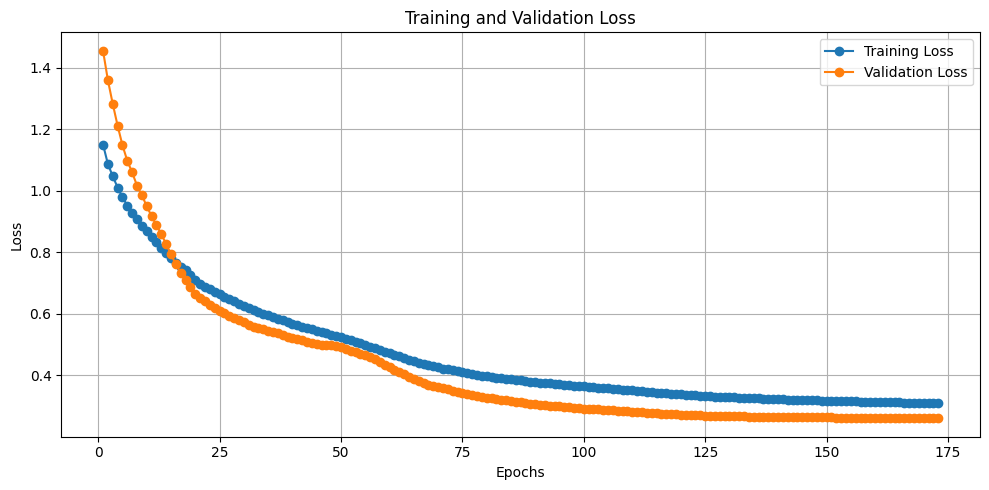

In [42]:
plot_train_val(training_loss, validation_loss)

# Qualitative Analysis

Test the trained embedding on the test set, as well as on a larger unseen image

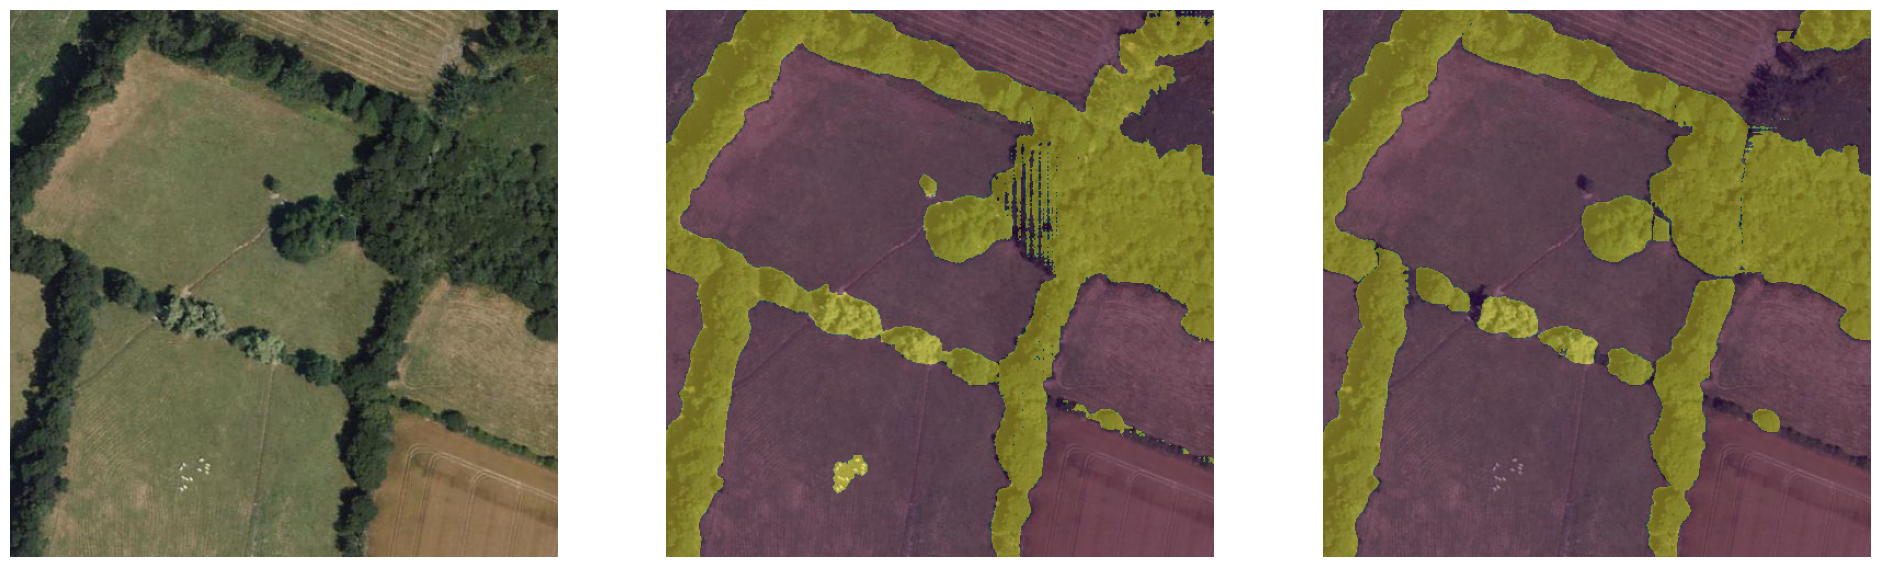

In [49]:
test_emb = test_embeddings[5]

test_mask = generate_trained_emb_mask(sam, test_emb["img"], prompt_embedding, fixed_dense_emb, (500, 500))
utils.show_masks(test_emb["img"], test_mask, additional_masks=[test_emb["gt_mask"]], size=8)

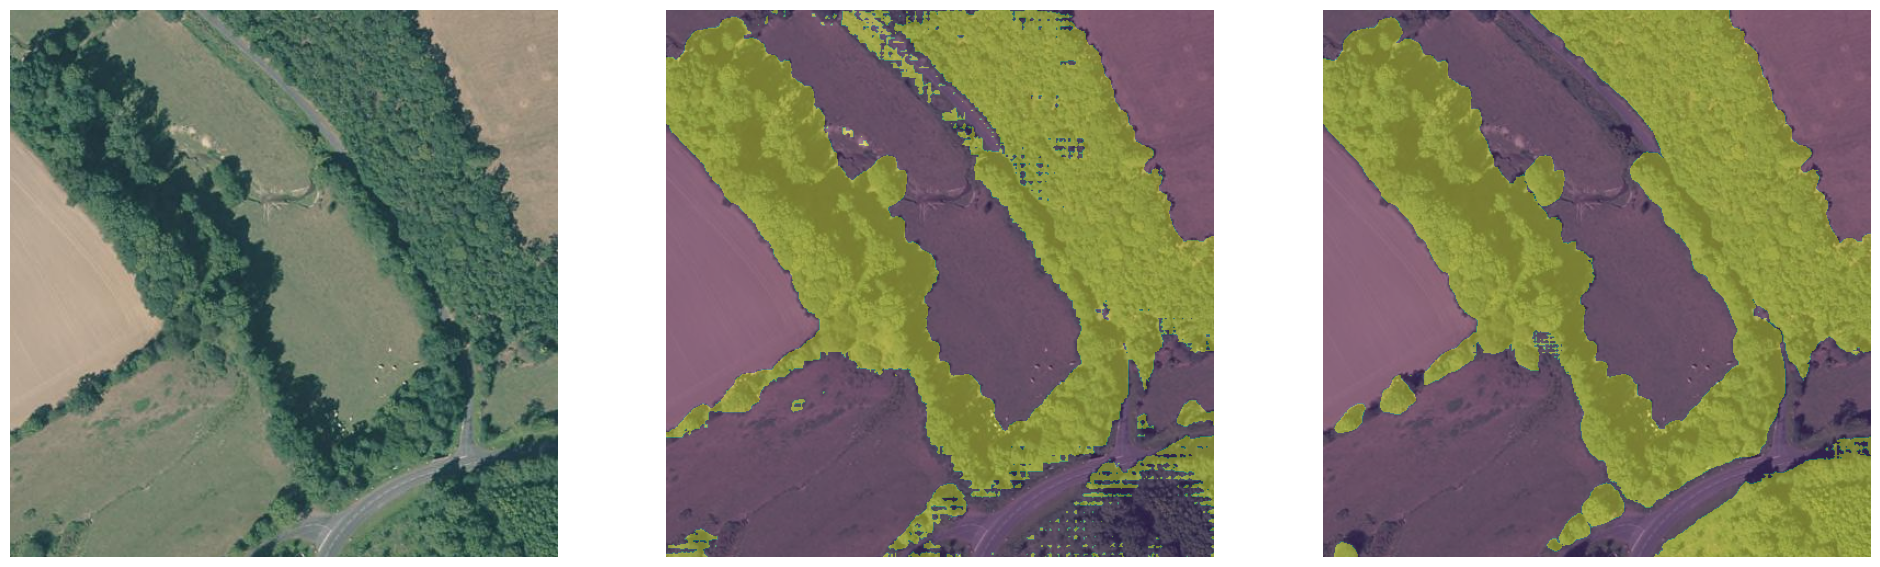

In [44]:
test_emb = test_embeddings[6]

test_mask = generate_trained_emb_mask(sam, test_emb["img"], prompt_embedding, fixed_dense_emb, (500, 500))
utils.show_masks(test_emb["img"], test_mask, additional_masks=[test_emb["gt_mask"]], size=8)

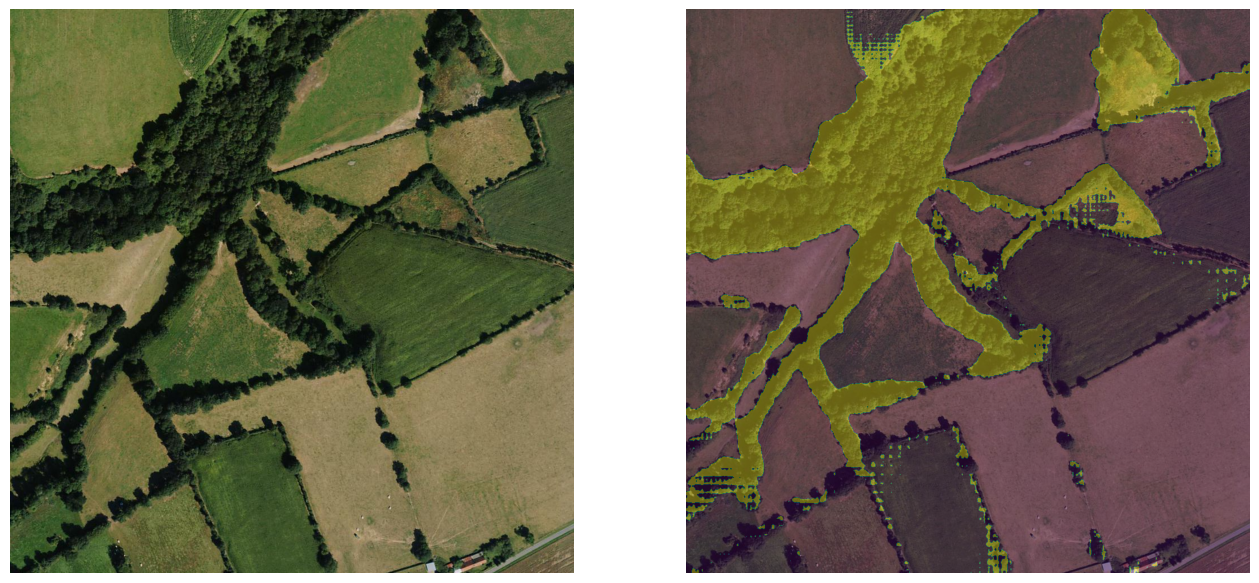

In [51]:
test_img = utils.load_image(dataset_dir+'/'+prompts[0]['img_path'])
partial_test_img = test_img[3000:4000, 3000:4000, :]

test_mask = generate_trained_emb_mask(sam, partial_test_img, prompt_embedding, fixed_dense_emb, (1000, 1000))
utils.show_masks(partial_test_img, test_mask, size=8)

# Quantitative Analysis

In [53]:
accuracies = []
f1_scores = []
ious = []

with torch.no_grad():
    for test_emb in test_embeddings:
        gt_mask_bin = utils.binarize_mask(test_emb["gt_mask"])
        
        pred_mask = generate_trained_emb_mask(sam, test_emb["img"], prompt_embedding, fixed_dense_emb, (500, 500))
        pred_mask_bin = utils.binarize_mask(pred_mask)
        
        acc, f1, iou = compute_metrics(pred_mask_bin, gt_mask_bin)
        
        accuracies.append(acc)
        f1_scores.append(f1)
        ious.append(iou)

In [54]:
print(f"Prediction mask Avg Accuracy score: {sum(accuracies) / len(accuracies)}")
print(f"Prediction mask Avg F1 score: {sum(f1_scores) / len(f1_scores)}")
print(f"Prediction mask Avg IoU score: {sum(ious) / len(ious)}")

Prediction mask Avg Accuracy score: 0.8950655999999999
Prediction mask Avg F1 score: 0.9230597891724001
Prediction mask Avg IoU score: 0.8601514385430484


# Save Embedding

In [ ]:
trained_embeddings = {}

In [ ]:
trained_embeddings["150 epochs, 0.8 alpha, 0.001 lr, 1e-4 decay, 7 seed"] = prompt_embedding

In [ ]:
torch.save(trained_embeddings, 'saved_embeddings.pth')